In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

import sklearn
import seaborn as sns

import matplotlib.font_manager as fm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import OrderedDict

fm.fontManager.addfont('ChosunSm.ttf')
prop = fm.FontProperties(fname='ChosunSm.ttf')
plt.rcParams["font.family"] = prop.get_name()
plt.rcParams["axes.unicode_minus"] = False


# AI Homework 2025, Homework #2 Report

## Load dataset

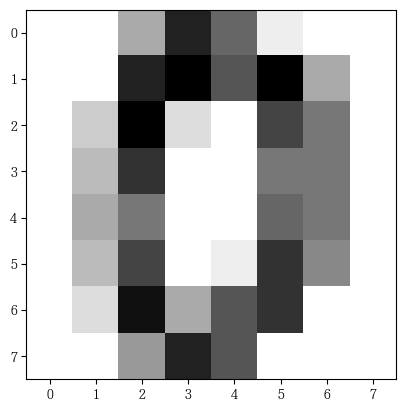

In [16]:
data = load_digits()
plt.imshow(data.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## Analysis about the datasets

In [ ]:
data.target

array([0, 1, 2, ..., 8, 9, 8], shape=(1797,))

=== 1. Basic Dataset Info ===
Total Samples: 1797
Feature Count: 64 (8x8 pixels flattened)
Target Classes: [0 1 2 3 4 5 6 7 8 9]
Feature Range: 0.0 ~ 16.0


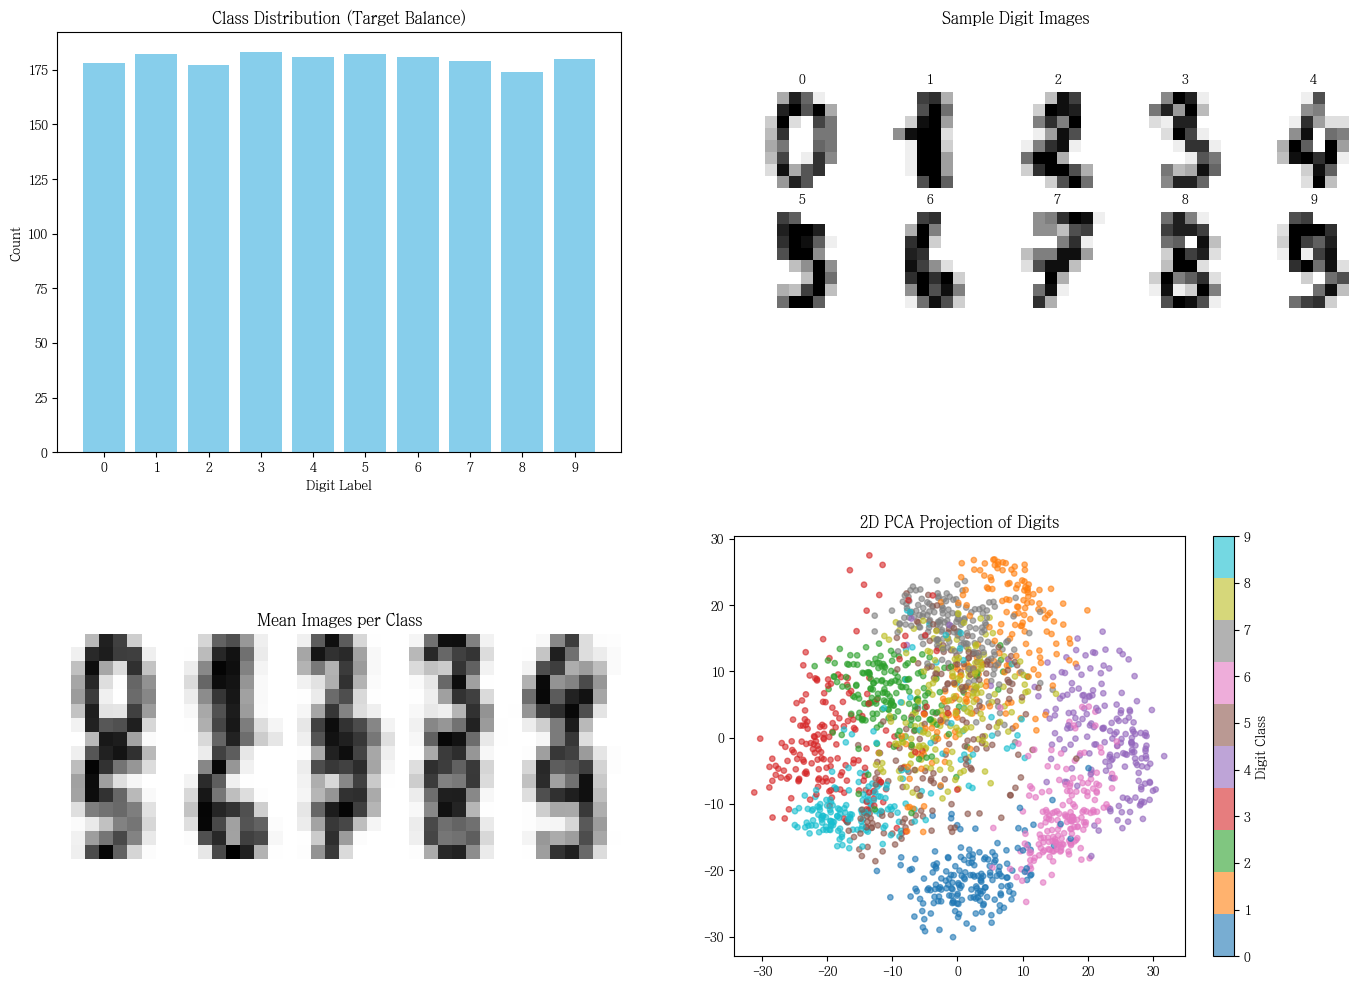

In [48]:
print("=== 1. Basic Dataset Info ===")
print(f"Total Samples: {data.data.shape[0]}")
print(f"Feature Count: {data.data.shape[1]} (8x8 pixels flattened)")
print(f"Target Classes: {data.target_names}")
print(f"Feature Range: {np.min(data.data)} ~ {np.max(data.data)}")
print("============================")

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(2, 2, 1)
labels, counts = np.unique(data.target, return_counts=True)
ax1.bar(labels, counts, color='skyblue', align='center')
ax1.set_title("Class Distribution (Target Balance)")
ax1.set_xlabel("Digit Label")
ax1.set_xticks(labels)
ax1.set_ylabel("Count")

ax2 = fig.add_subplot(2, 2, 2)
ax2.axis('off')
ax2.set_title("Sample Digit Images")
for i in range(10):
    sub_ax = fig.add_axes([0.55 + (i % 5) * 0.08, 0.75 - (i // 5) * 0.1, 0.08, 0.08])
    sub_ax.imshow(data.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    sub_ax.axis('off')
    sub_ax.set_title(str(data.target[i]), fontsize=10)

ax3 = fig.add_subplot(2, 2, 3)
mean_images = []
for i in range(10):
    mean_images.append(np.mean(data.images[data.target == i], axis=0))

combined_img = np.zeros((8 * 2, 8 * 5))
for i in range(10):
    row = i // 5
    col = i % 5
    combined_img[row*8:(row+1)*8, col*8:(col+1)*8] = mean_images[i]
ax3.imshow(combined_img, cmap=plt.cm.gray_r, interpolation='nearest')
ax3.set_title("Mean Images per Class")
ax3.axis('off')

ax4 = fig.add_subplot(2, 2, 4)
pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(data.data)

scatter = ax4.scatter(X_pca[:, 0], X_pca[:, 1], c=data.target, cmap='tab10', alpha=0.6, s= 15)
ax4.set_title("2D PCA Projection of Digits")
#ax4.set_xlabel("PCA Component 1")
#ax4.set_ylabel("PCA Component 2")
plt.colorbar(scatter, ax=ax4, label = "Digit Class")

#plt.tight_layout()
plt.show()

데이터 개요 (Overview):

    총 1,797개의 샘플이 있으며, 각 샘플은 8x8 픽셀(64개 feature)로 이루어진 흑백(grayscale) 이미지이다.

    각 픽셀 값은 0(흰색)부터 16(검은색) 사이의 정수 값을 가진다. (이 때문에 학습 전 StandardScaler를 이용한 정규화가 필요함을 언급하면 좋습니다.)

클래스 균형 (Class Balance):

    첫 번째 그래프(Bar chart)를 보면 0부터 9까지의 데이터 개수가 거의 비슷하다.

    분석: 데이터 불균형(Imbalance) 문제가 없으므로, 정확도(Accuracy)를 주요 평가지표로 사용해도 타당하다.

데이터의 특징 (Characteristics):

    세 번째 그림(Average Image)을 보면, 같은 숫자라도 필기체라 모양이 조금씩 다르지만 평균을 내보면 숫자의 형태가 뚜렷하게 나타난다.

    이는 픽셀 데이터 간에 일관된 패턴이 존재함을 의미한다.

분류 가능성 (Separability - PCA Plot):

    마지막 산점도(PCA)를 보면, 64차원을 2차원으로 줄였음에도 불구하고 같은 색깔(같은 숫자)끼리 잘 뭉쳐 있고, 다른 색깔과는 분리되는 경향을 보인다.

    분석: 이는 데이터가 비교적 선형적으로 분리 가능하거나(Linearly Separable) 패턴이 뚜렷하여, SVM이나 Logistic Regression 같은 알고리즘으로도 높은 성능을 낼 수 있음을 시사한다.

## reproducing Datasets

In [17]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data.data, data.target, test_size=0.2, random_state=8
)

In [18]:
scaler = sklearn.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled.reshape(-1, 1, 8, 8), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 1, 8, 8), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Preparing Models

In [19]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)

        x = x.view(-1, 32 * 4 * 4)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x
    
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc_layer(x)
        return x
    

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x
        return out
    
class AttentionCNN(nn.Module):
    def __init__(self):
        super(AttentionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            SelfAttention(32)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            SelfAttention(64),
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc_layer(x)
        return x

In [20]:
class MicroViT(nn.Module):
    def __init__(self, image_size=8, patch_size=2, num_classes=10, dim=64, depth=4, heads=4, mlp_dim=128):
        super(MicroViT, self).__init__()
    
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 1 * patch_size * patch_size
        
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

        self.patch_size = patch_size
        self.dim = dim

    def forward(self, img):
        # img shape: (batch, 1, 8, 8)
        p = self.patch_size
        # Flatten Patches
        # (batch, 1, 8, 8) -> (batch, 16, 4)
        x = img.unfold(2, p, p).unfold(3, p, p).permute(0, 2, 3, 1, 4, 5).contiguous().view(img.shape[0], -1, p*p)
        # Embedding
        x = self.patch_to_embedding(x) # (batch, 16, 64)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # (batch, 17, 64)
        x += self.pos_embedding[:, :(x.shape[1])]
        x = self.transformer(x)
        x = x[:, 0]
        return self.mlp_head(x)

In [21]:
# Model Declaration
models = {
    "Logistic Regression": sklearn.linear_model.LogisticRegression(random_state=8),
    "KNN (k=3)": sklearn.neighbors.KNeighborsClassifier(n_neighbors=3),
    "KNN (k=5)": sklearn.neighbors.KNeighborsClassifier(n_neighbors=5),
    "KNN (k=7)": sklearn.neighbors.KNeighborsClassifier(n_neighbors=7),
    "SVM-rbf": sklearn.svm.SVC(kernel = 'rbf', random_state=8),
    "SVM-linear": sklearn.svm.SVC(kernel='linear', random_state=8),
    "SVM-sigmoid": sklearn.svm.SVC(kernel="sigmoid", random_state=8),
    "Decision Tree": sklearn.tree.DecisionTreeClassifier(random_state=8),
    "Random Forest (50)": sklearn.ensemble.RandomForestClassifier(n_estimators=50, random_state=8),
    "Random Forest (100)": sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=8),

    "FDA": sklearn.discriminant_analysis.LinearDiscriminantAnalysis(),
    "Gaussian NB": sklearn.naive_bayes.GaussianNB(),
    "MLP (100)": sklearn.neural_network.MLPClassifier(random_state=8, hidden_layer_sizes=(100,)),
    "MLP (200)": sklearn.neural_network.MLPClassifier(random_state=8, hidden_layer_sizes=(200,)),
    "MLP (256)": sklearn.neural_network.MLPClassifier(random_state=8, hidden_layer_sizes=(256,)),

    "Ensenble (Hard Voting)": sklearn.ensemble.VotingClassifier(estimators=
        [
            ('knn', sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)),
            ('svm', sklearn.svm.SVC(kernel='rbf', random_state=8)),
            ('mlp', sklearn.neural_network.MLPClassifier(random_state=8, hidden_layer_sizes=(200,)))
        ],
        voting='hard'
    ),
}

results = OrderedDict()

In [22]:
# scikit-learn Model
for name, model in models.items():
    # Model
    model.fit(X_train_scaled, y_train)
    
    # Prediction
    y_pred = model.predict(X_test_scaled)
    
    # Evaluation
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    results[name] = acc



In [23]:
# CNN

model = DigitCNN()
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_ds = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

epochs = 20

for ep in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = model(inputs)
        loss = crit(pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {ep+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)

    _, predicted = torch.max(outputs, 1)

    correct = (predicted == y_test_tensor).sum().item()
    total = len(y_test_tensor)

    acc = correct / total
    results["CNN(Basic)"] = acc

models["CNN(Basic)"] = model

Epoch 1/20, Loss: 1.4835
Epoch 2/20, Loss: 0.3041
Epoch 3/20, Loss: 0.1692
Epoch 4/20, Loss: 0.1133
Epoch 5/20, Loss: 0.0763
Epoch 6/20, Loss: 0.0634
Epoch 7/20, Loss: 0.0397
Epoch 8/20, Loss: 0.0345
Epoch 9/20, Loss: 0.0372
Epoch 10/20, Loss: 0.0189
Epoch 11/20, Loss: 0.0167
Epoch 12/20, Loss: 0.0132
Epoch 13/20, Loss: 0.0096
Epoch 14/20, Loss: 0.0092
Epoch 15/20, Loss: 0.0080
Epoch 16/20, Loss: 0.0074
Epoch 17/20, Loss: 0.0044
Epoch 18/20, Loss: 0.0039
Epoch 19/20, Loss: 0.0025
Epoch 20/20, Loss: 0.0021


In [24]:
# More Advanced CNN

model = AdvancedCNN()
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

train_ds = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 30

for ep in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = model(inputs)
        loss = crit(pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    
    print(f"Epoch {ep+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)

    _, predicted = torch.max(outputs, 1)

    correct = (predicted == y_test_tensor).sum().item()
    total = len(y_test_tensor)

    acc = correct / total
    results["CNN(Advanced)"] = acc

models["CNN(Advanced)"] = model

Epoch 1/30, Loss: 1.0062
Epoch 2/30, Loss: 0.2038
Epoch 3/30, Loss: 0.0946
Epoch 4/30, Loss: 0.0699
Epoch 5/30, Loss: 0.0722
Epoch 6/30, Loss: 0.0523
Epoch 7/30, Loss: 0.0287
Epoch 8/30, Loss: 0.0869
Epoch 9/30, Loss: 0.0896
Epoch 10/30, Loss: 0.0572
Epoch 11/30, Loss: 0.0138
Epoch 12/30, Loss: 0.0083
Epoch 13/30, Loss: 0.0079
Epoch 14/30, Loss: 0.0040
Epoch 15/30, Loss: 0.0025
Epoch 16/30, Loss: 0.0031
Epoch 17/30, Loss: 0.0030
Epoch 18/30, Loss: 0.0014
Epoch 19/30, Loss: 0.0074
Epoch 20/30, Loss: 0.0023
Epoch 21/30, Loss: 0.0028
Epoch 22/30, Loss: 0.0028
Epoch 23/30, Loss: 0.0015
Epoch 24/30, Loss: 0.0014
Epoch 25/30, Loss: 0.0014
Epoch 26/30, Loss: 0.0028
Epoch 27/30, Loss: 0.0019
Epoch 28/30, Loss: 0.0016
Epoch 29/30, Loss: 0.0009
Epoch 30/30, Loss: 0.0011


In [25]:
# Attention CNN

model = AttentionCNN()
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

train_ds = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 30

for ep in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = model(inputs)
        loss = crit(pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    
    print(f"Epoch {ep+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)

    _, predicted = torch.max(outputs, 1)

    correct = (predicted == y_test_tensor).sum().item()
    total = len(y_test_tensor)

    acc = correct / total
    results["CNN(Attention)"] = acc

models["CNN(Attention)"] = model

Epoch 1/30, Loss: 0.9964
Epoch 2/30, Loss: 0.1444
Epoch 3/30, Loss: 0.1252
Epoch 4/30, Loss: 0.0942
Epoch 5/30, Loss: 0.0990
Epoch 6/30, Loss: 0.0206
Epoch 7/30, Loss: 0.0215
Epoch 8/30, Loss: 0.0290
Epoch 9/30, Loss: 0.0399
Epoch 10/30, Loss: 0.0283
Epoch 11/30, Loss: 0.0218
Epoch 12/30, Loss: 0.0047
Epoch 13/30, Loss: 0.0032
Epoch 14/30, Loss: 0.0030
Epoch 15/30, Loss: 0.0016
Epoch 16/30, Loss: 0.0017
Epoch 17/30, Loss: 0.0016
Epoch 18/30, Loss: 0.0011
Epoch 19/30, Loss: 0.0014
Epoch 20/30, Loss: 0.0015
Epoch 21/30, Loss: 0.0016
Epoch 22/30, Loss: 0.0009
Epoch 23/30, Loss: 0.0013
Epoch 24/30, Loss: 0.0005
Epoch 25/30, Loss: 0.0009
Epoch 26/30, Loss: 0.0011
Epoch 27/30, Loss: 0.0005
Epoch 28/30, Loss: 0.0015
Epoch 29/30, Loss: 0.0011
Epoch 30/30, Loss: 0.0005


In [26]:
# Micro ViT
train_ds = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

model = MicroViT()
crit = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
epochs = 50

for ep in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = model(inputs)
        loss = crit(pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    
    print(f"Epoch {ep+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)

    _, predicted = torch.max(outputs, 1)

    correct = (predicted == y_test_tensor).sum().item()
    total = len(y_test_tensor)

    acc = correct / total
    results["MicroViT"] = acc

models["MicroViT"] = model

Epoch 1/50, Loss: 1.7488
Epoch 2/50, Loss: 0.5374
Epoch 3/50, Loss: 0.2700
Epoch 4/50, Loss: 0.1750
Epoch 5/50, Loss: 0.1070
Epoch 6/50, Loss: 0.0909
Epoch 7/50, Loss: 0.0724
Epoch 8/50, Loss: 0.0588
Epoch 9/50, Loss: 0.0535
Epoch 10/50, Loss: 0.0513
Epoch 11/50, Loss: 0.0481
Epoch 12/50, Loss: 0.0489
Epoch 13/50, Loss: 0.0683
Epoch 14/50, Loss: 0.0676
Epoch 15/50, Loss: 0.0413
Epoch 16/50, Loss: 0.0394
Epoch 17/50, Loss: 0.0257
Epoch 18/50, Loss: 0.0174
Epoch 19/50, Loss: 0.0241
Epoch 20/50, Loss: 0.0203
Epoch 21/50, Loss: 0.0109
Epoch 22/50, Loss: 0.0087
Epoch 23/50, Loss: 0.0105
Epoch 24/50, Loss: 0.0111
Epoch 25/50, Loss: 0.0082
Epoch 26/50, Loss: 0.0050
Epoch 27/50, Loss: 0.0032
Epoch 28/50, Loss: 0.0040
Epoch 29/50, Loss: 0.0050
Epoch 30/50, Loss: 0.0060
Epoch 31/50, Loss: 0.0035
Epoch 32/50, Loss: 0.0024
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0038
Epoch 35/50, Loss: 0.0020
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0042
Epoch 39/50, Loss: 0.

Algorithm                           | Accuracy  
--------------------------------------------------
CNN(Advanced)                       | 0.9889
CNN(Attention)                      | 0.9861
Ensenble (Hard Voting)              | 0.9833
MicroViT                            | 0.9833
CNN(Basic)                          | 0.9806
KNN (k=5)                           | 0.9778
SVM-rbf                             | 0.9778
MLP (200)                           | 0.9778
KNN (k=3)                           | 0.9750
KNN (k=7)                           | 0.9750
MLP (256)                           | 0.9750
SVM-linear                          | 0.9722
Random Forest (50)                  | 0.9722
MLP (100)                           | 0.9722
Logistic Regression                 | 0.9667
Random Forest (100)                 | 0.9667
FDA                                 | 0.9583
SVM-sigmoid                         | 0.9528
Decision Tree                       | 0.8556
Gaussian NB                         | 0.7750


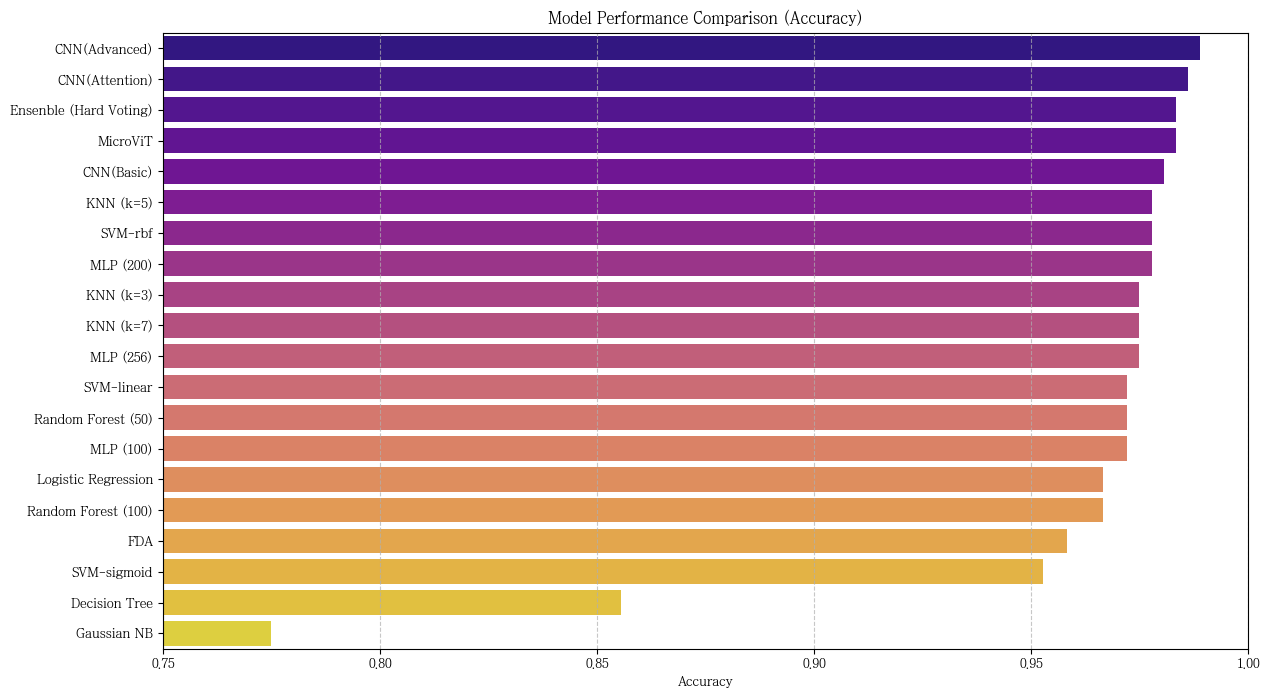

In [27]:
print(f"{'Algorithm':<35} | {'Accuracy':<10}")
print("-" * 50)

results = OrderedDict(
    sorted(results.items(), key=lambda item: item[1], reverse=True)
)

# --- 5. 결과 시각화 ---
for model, acc in results.items():
    print(f"{model:<35} | {acc:.4f}")


plt.figure(figsize=(14, 8))
sns.barplot(x=list(results.values()), y=list(results.keys()), hue=list(results.keys()), palette="plasma", legend=False)
plt.title("Model Performance Comparison (Accuracy)")
plt.xlabel("Accuracy")
plt.xlim(0.75, 1.0) # 정확도 차이를 잘 보기 위해 범위 조정
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Error Analysis



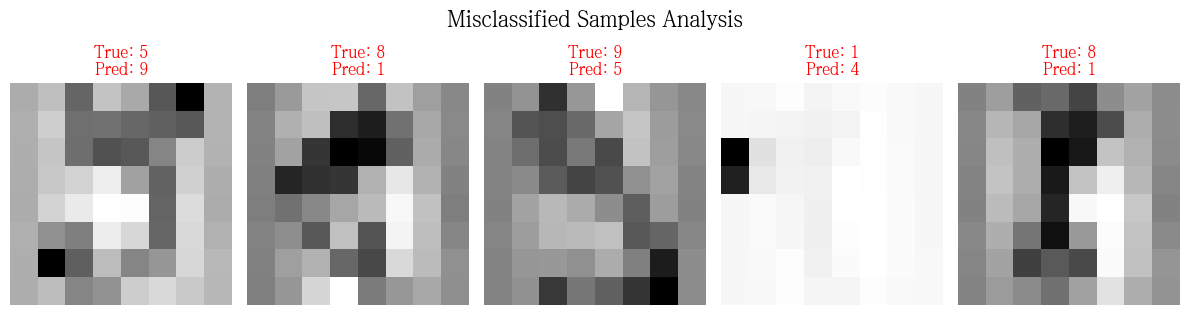

In [33]:
model = models["CNN(Attention)"]
model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    
    # 정답과 예측이 다른 인덱스 추출
    wrong_indices = (predicted != y_test_tensor).nonzero(as_tuple=True)[0].numpy()
    
    # 실제 라벨과 예측 라벨 가져오기
    wrong_labels = y_test_tensor[wrong_indices].numpy()
    wrong_preds = predicted[wrong_indices].numpy()
    wrong_images = X_test_tensor[wrong_indices].numpy()

# 시각화 (최대 10개만)
plt.figure(figsize=(12, 6))
num_show = min(10, len(wrong_indices))

for i in range(num_show):
    ax = plt.subplot(2, 5, i + 1)
    # 이미지 형태 복원 (1, 8, 8) -> (8, 8)
    img = wrong_images[i].reshape(8, 8) 
    ax.imshow(img, cmap='gray_r')
    ax.set_title(f"True: {wrong_labels[i]}\nPred: {wrong_preds[i]}", color='red')
    ax.axis('off')

plt.suptitle("Misclassified Samples Analysis", fontsize=16)
plt.tight_layout()
plt.show()